# IVUS Challenge

In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import cv2
import os
import keras

seed = 123
version = 0

2022-01-20 22:35:08.480842: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Prepare the data

### Read the images
The images are stored in the <i>Training_Set</i> folder. We will load the images from <i>Data_set_A</i>:

An empirical number of five temporally adjacent frames around the frame $F$ (two before and two after) have been included. It has been considered when more than two frames forward (and backward) in time are considered, consecutive IVUS frames might not be aligned. 

-  A training set: A subset (one fourth) of images from each dataset containing both images and manual annotations. The training set is meant for training and tuning of the algorithms prior to the evaluation. This dataset is distributed upon request for algorithm evaluation.
- A test set: The remaining frames compose the set of images that are used for performance evaluation. The annotations are not available before the algorithm evaluation in order to assure the complete blindness and equity of the algorithm assessment.

Annotations on the image datasets have been provided by four clinical experts, daily working with the specific IVUS echograph brand, and belonging to distinct medical centers. The annotation consists in the delineation of both inner wall (lumen contours) and outer wall (media/adventitia contours) on the IVUS images in the short-axis view. In all the cases, the experts were blinded to the other physicians’ annotations, and two of them repeated the manual annotations after about one week from the first labeling.


In [2]:
# Helper functions
def read_labels(directory, verbose=1):
    """
    Reads the labels from a given directory
    
    returns:
        A dictionary containing:
            'lum': array of labels of 2D coordinates
            'med': array of labels of 2D coordinates
    """
    labels_lum = []
    labels_med = []

    for file_name in sorted(os.listdir(directory)):
        points = []
        with open(os.path.join(directory, file_name)) as f:
            for line in f:
                c0, c1 = line.split(',')
                points.append((float(c0), float(c1)))

        if file_name.startswith("lum"):
            labels_lum.append(points)
        elif file_name.startswith("med"):
            labels_med.append(points)
    
    # We will have imbalances since the number of coordinates is not fixed
    # To use numpy array, we will extend every list of labels repeating the last element
    labels_lum = np.array(labels_lum, dtype=object)
    if type(labels_lum[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_lum[i]) for i in range(len(labels_lum))])
        for i in range(len(labels_lum)):
            labels_lum[i] = np.concatenate(
                (labels_lum[i], np.repeat([labels_lum[i][-1]],m-len(labels_lum[i]), axis=0))
            )
    
    labels_med = np.array(labels_med, dtype=object)
    if type(labels_med[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_med[i]) for i in range(len(labels_med))])
        for i in range(len(labels_med)):
            labels_med[i] = np.concatenate(
                (labels_med[i], np.repeat([labels_med[i][-1]],m-len(labels_med[i]), axis=0))
            )

    # We have np.arrays inside np.arrays, we have to undo this
    labels = {
        'lum': np.array([l.tolist() for l in labels_lum]),
        'med': np.array([l.tolist() for l in labels_med])
    }

    if verbose:
        print(f"Annotation for the inner wall (lumen contours): {labels['lum'].shape}")
        print(f"Annotation for the outer wall (media/adventitia contours): {labels['med'].shape}")
        
    return labels

def read_training_dataset(letter="A", verbose=1):
    """
    Reads the training dataset A or B
    
    returns:
        Two tuples (x_train, y_train_label), (x_test, y_test_label):
            x_train: dataset of images for training
            y_train_label: a dictionary containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
            x_test: dataset of images for testing
            y_test_label: a list of 3 dictionaries containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
    """
    path = os.path.join(os.getcwd(), "Training_Set", "Data_set_"+letter, "DCM")

    dataset = []
    subset = []

    count = 0
    for file_name in sorted(os.listdir(path)):
        count += 1
        subset.append(cv2.imread(os.path.join(path, file_name), cv2.IMREAD_GRAYSCALE))

        if count >= 5:
            dataset.append(subset)
            subset = []
            count = 0

    dataset = np.array(dataset)
    
    if verbose:
        print(f"Dataset {letter} has shape: {dataset.shape}")
    
    # Read the labels
    y_train_labels = []
    y_train_directory = os.path.join(os.getcwd(), "Training_Set", "Data_set_"+letter, "LABELS")
    for dir_name in ['LABELS_obs1']:
        directory = os.path.join(y_train_directory, dir_name)
        y_train_labels.append(read_labels(directory, verbose))
    
    num_training_labels = y_train_labels[0]['lum'].shape[0]
    x_train = dataset[:num_training_labels, :, :, :]
    
    x_test = dataset[num_training_labels:, :, :, :]
    
    # Read test labels
    y_test_labels = []
    y_test_directory = os.path.join(os.getcwd(), "Test_Set", "Data_set_"+letter)
    for dir_name in ['LABELS_obs1', 'LABELS_obs2_v1', 'LABELS_obs2_v2']:
        directory = os.path.join(y_test_directory, dir_name)
        y_test_labels.append(read_labels(directory, verbose))
    
    return (x_train, y_train_labels), (x_test, y_test_labels)

In [3]:
(x_train, y_train_labels), (x_test, y_test_labels) = read_training_dataset("B")

Dataset B has shape: (435, 5, 384, 384)
Annotation for the inner wall (lumen contours): (109, 360, 2)
Annotation for the outer wall (media/adventitia contours): (109, 360, 2)
Annotation for the inner wall (lumen contours): (326, 360, 2)
Annotation for the outer wall (media/adventitia contours): (326, 360, 2)
Annotation for the inner wall (lumen contours): (326, 581, 2)
Annotation for the outer wall (media/adventitia contours): (326, 719, 2)
Annotation for the inner wall (lumen contours): (326, 583, 2)
Annotation for the outer wall (media/adventitia contours): (326, 720, 2)


In [4]:
from skimage.measure import block_reduce
def downsample_image(image):
    """Downsample image by half by applying mean pooling"""
    return block_reduce(image, block_size=(2,2), func=np.mean)

In [5]:
x_train_ds = []
for batch in x_train:
    x_train_ds.append([downsample_image(image) for image in batch])

x_train_ds = np.array(x_train_ds)
y_train_label_ds = []
for label in y_train_labels:
    y_train_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

x_test_ds = []
for batch in x_test:
    x_test_ds.append([downsample_image(image) for image in batch])

x_test_ds = np.array(x_test_ds)
y_test_label_ds = []
for label in y_test_labels:
    y_test_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

print(f"Training set now has shape {x_train_ds.shape}")
print(f"Test set now has shape {x_test_ds.shape}")

Training set now has shape (109, 5, 192, 192)
Test set now has shape (326, 5, 192, 192)


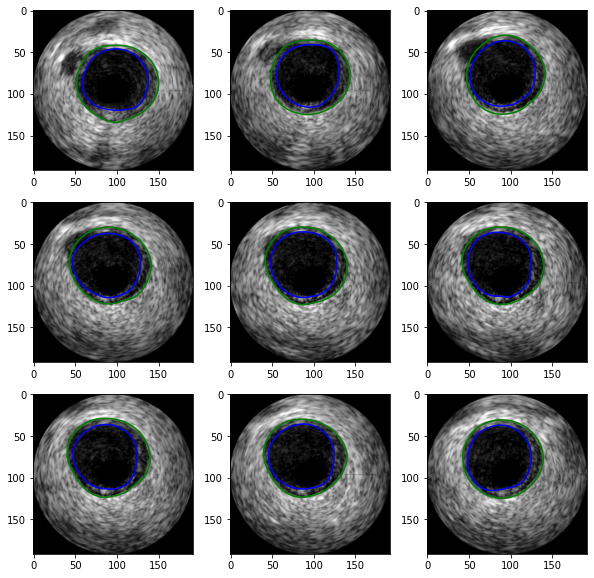

In [6]:
# Display some images
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.plot(y_train_label_ds[0]['lum'][i][:, 0], y_train_label_ds[0]['lum'][i][:, 1], 'b-')
    plt.plot(y_train_label_ds[0]['med'][i][:, 0], y_train_label_ds[0]['med'][i][:, 1], 'g-')
    plt.imshow(x_train_ds[i][2], cmap='gray')

### Create a set of mask images
We will use the labels we have to mask the interior of the paths they draw. Since we have three different classes: background, media and lumen; we will create a multiclass segmentation.

In [7]:
num_classes = 3
CLASSES = ['background', 'media', 'lumen']

In [8]:
def create_masks(x, y):
    """
    Create masks from a dataset and its labels
    
    parameters:
        x: dataset of images
        y: array of labels of 2D coordinates
    returns:
        An array containing multiclass images segmented as follows:
            - Value 0 represents background
            - Value 1 represents the media
            - Value 2 represents the lumen
    """
    
    masks = []

    for i in range(y['lum'].shape[0]):
        # Retrieve path from the label
        path_lum = Path(y['lum'][i])
        path_med = Path(y['med'][i])
        img = x[i][2]

        # Create a matrix of coordinates to check which points are inside the closed path
        img_meshgrid = np.array(np.meshgrid(*(np.arange(s) for s in img.shape[:2]), indexing='xy'))
        img_coordinates = img_meshgrid.transpose([1,2,0]).reshape(img.shape[0]*img.shape[1],2)
        mask_lum = path_lum.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])
        mask_med = path_med.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])

        final_mask = mask_lum.astype(int) + mask_med.astype(int)
        
        masks.append(final_mask)
        
    return np.array(masks)

def get_one_hot(targets, nb_classes):
    """Returns the targets as one-hot encoded"""
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

### One-hot encoding
We one-hot encode our labels in the following way:
- Background pixels: [1, 0, 0]
- Media pixels: [0, 1, 0]
- Lumen pixels: [0, 0, 1]

This encoding will help optimize our model because we plan to output the probability of each pixel belonging to a certain class.

In [9]:
masks = np.concatenate(
    [create_masks(x_train_ds, observer_labels) for observer_labels in y_train_label_ds]
)
    
y_train_ds = get_one_hot(masks, num_classes)
x_train_ds = np.concatenate([x_train_ds for _ in range(len(y_train_label_ds))])

In [10]:
# GET TEST IMAGES
masks = np.concatenate(
    [create_masks(x_test_ds, observer_labels) for observer_labels in y_test_label_ds]
)
    
y_test_ds = get_one_hot(masks, num_classes)
x_test_ds = np.concatenate([x_test_ds for _ in range(len(y_test_label_ds))])

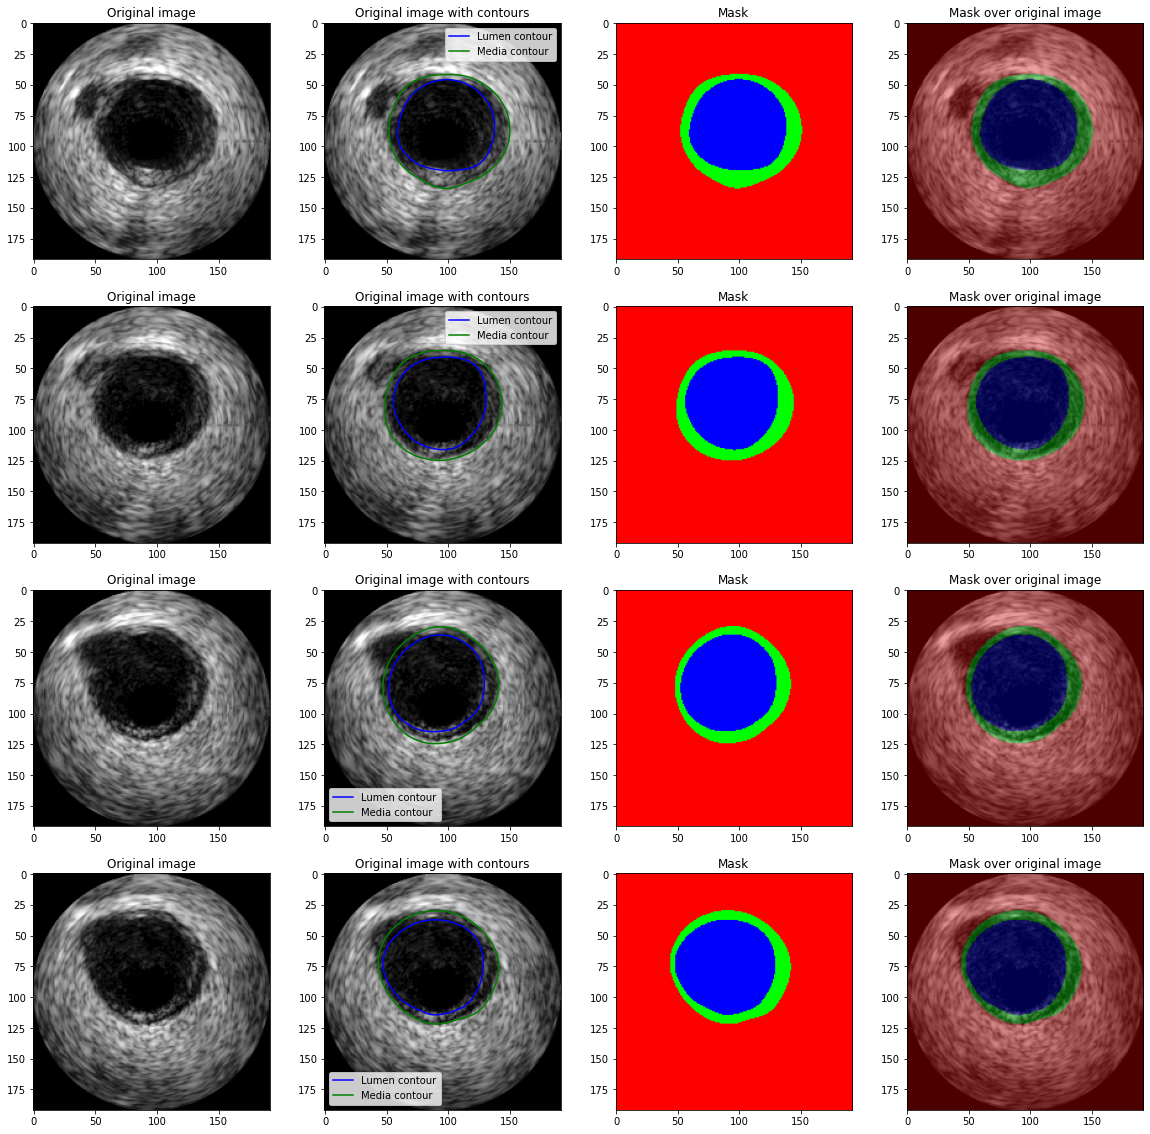

In [11]:
# Let's show some examples
plt.figure(figsize=(20, 20))

samples = 4

for i in range(samples):
    
    
    ax = plt.subplot(samples, 4, 4*i + 1)
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image')
    
    ax = plt.subplot(samples, 4, 4*i + 2)
    plt.plot(y_train_label_ds[0]['lum'][i][:, 0], y_train_label_ds[0]['lum'][i][:, 1], 'b-', label='Lumen contour')
    plt.plot(y_train_label_ds[0]['med'][i][:, 0], y_train_label_ds[0]['med'][i][:, 1], 'g-', label='Media contour')
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image with contours')
    plt.legend()
    
    
    mask = y_train_ds[i]/y_train_ds.max()
    ax = plt.subplot(samples, 4, 4*i + 3)
    plt.imshow(mask)
    plt.title('Mask')
    
    
    image = np.repeat(x_train_ds[i][2][..., np.newaxis], 3, axis=2)
    alpha = 0.7
    ax = plt.subplot(samples, 4, 4*i + 4)
    plt.imshow(np.uint8(image*alpha + mask*255*(1-alpha)))
    plt.title('Mask over original image')

### Data augmentation
We have 19 images to train using dataset A and 109 images in dataset B. Therefore we should apply Data Augmentation in order to get more training examples to feed into our model.

In this test we will only use the images adjacent to the middle image and we will pass these 3 images as 3 channels RGB to the data generator.

In [12]:
images = x_train_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (109, 384, 384, 3) (for dataset B)
masks = y_train_ds # Now the shape is (109, 384, 384, channels) (for dataset B)
num_classes = 3

print(f"Shape of set images: {images.shape}")
print(f"Shape of set masks: {masks.shape}")


batch_size = 8
input_shape = images.shape[1:] # (384, 384, 3)

images_test = x_test_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (num_images, 384, 384, 3) (for dataset B)
masks_test = np.copy(y_test_ds) # Now the shape is (num_images, 192, 192, channels) (for dataset B)

    
print(f"Shape of set images_test: {images_test.shape}")
print(f"Shape of set masks_test: {masks_test.shape}")

Shape of set images: (109, 192, 192, 3)
Shape of set masks: (109, 192, 192, 3)
Shape of set images_test: (978, 192, 192, 3)
Shape of set masks_test: (978, 192, 192, 3)


In [13]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 20

def get_image_generator(data_gen_args=dict(data_format="channels_last", validation_split=0.15),
                        images=images,
                        masks=masks,
                        batch_size=batch_size):
    # we create two instances with the same arguments
    val_data_gen_args = dict(
        data_format=data_gen_args['data_format'],
        validation_split=data_gen_args['validation_split']
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    val_datagen = ImageDataGenerator(**val_data_gen_args)

    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    # Provide the same seed and keyword arguments to the fit and flow methods
    image_generator = image_datagen.flow(images, seed=seed, batch_size=batch_size, subset='training')
    mask_generator = mask_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='training')

    image_val_generator = val_datagen.flow(images, seed=seed, batch_size=batch_size, subset='validation')
    mask_val_generator = val_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='validation')

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    val_generator = zip(image_val_generator, mask_val_generator)
    
    return train_generator, val_generator

def gen_dtype(gen):
    while True:
        for i,j in gen:
            yield (i.astype('float32'), j.astype('float32'))

#def gen_dtype_test(gen):
#    for i,j in gen:
#        yield (i.astype('float32'), to_categorical(j.astype('int'), num_classes=num_classes))

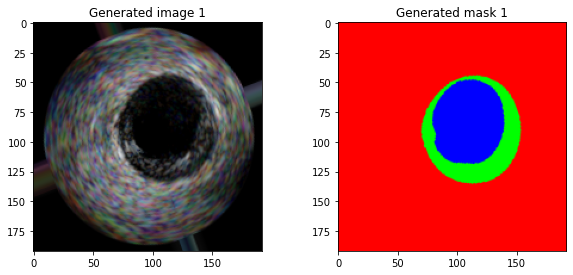

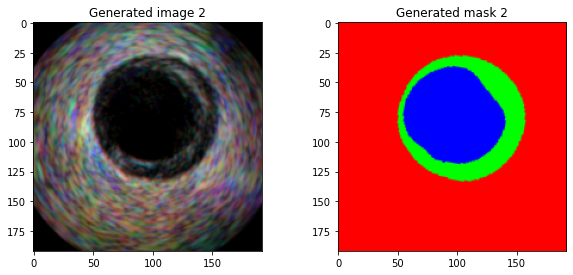

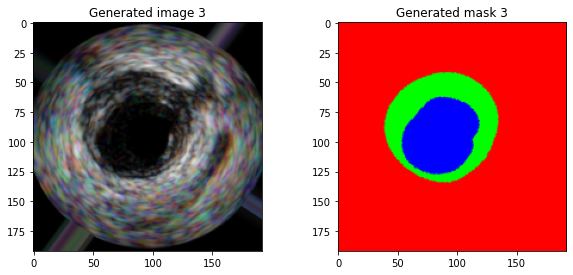

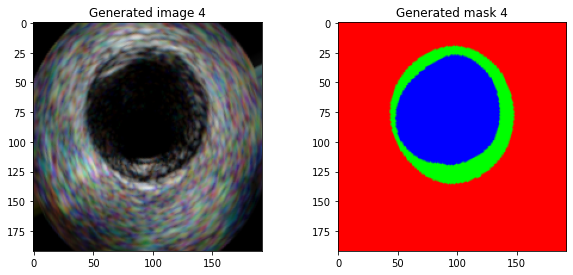

In [14]:
# Let's show some example
data_gen_args = dict(
    rotation_range=90,
    zoom_range=0.2,
    data_format="channels_last",
    validation_split=0.15
)
train_generator, val_generator = get_image_generator(data_gen_args)
images_gen, masks_gen = next(gen_dtype(train_generator))
samples = len(images_gen)

for i in range(4):
    plt.figure(figsize=(10,100))
    plt.subplot(samples, 2, 2*i+1)
    plt.imshow(images_gen[i], cmap='gray')
    plt.title(f"Generated image {i+1}")
    
    plt.subplot(samples, 2, 2*i+2)
    plt.imshow(masks_gen[i])
    plt.title(f"Generated mask {i+1}")

## Prepare and train the model
In this test we will use the <i>U-Net Xception-style</i> model from [this tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


def get_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(input_shape, num_classes)
model.summary()

2022-01-20 22:36:55.068523: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-20 22:36:55.103875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 22:36:55.103993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 with Max-Q Design computeCapability: 6.1
coreClock: 1.48GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-01-20 22:36:55.104014: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-20 22:36:55.117954: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-20 22:36:55.118006: I tensorflow/st

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## K-Fold crossvalidation

In [16]:
# Classification metrics
def get_specificity(col, cm):
    """Return the specificity of a variable in a 3x3 confusion matrix"""
    col_bef = (col-1)%3
    col_aft = (col+1)%3
    
    tp = cm[col,col]
    tn = cm[col_bef,col_bef] + cm[col_aft,col_aft]
    fp = cm[col_bef,col] + cm[col_aft,col]
    fn = cm[col,col_bef] + cm[col,col_aft]
    
    return float(tn)/float(tn+fp)

def get_accuracy(col, cm):
    """Return the accuracy of a variable in a 3x3 confusion matrix"""
    col_bef = (col-1)%3
    col_aft = (col+1)%3
    
    tp = cm[col,col]
    tn = cm[col_bef,col_bef] + cm[col_aft,col_aft]
    fp = cm[col_bef,col] + cm[col_aft,col]
    fn = cm[col,col_bef] + cm[col,col_aft]
    
    return float(tp+tn)/float(tp+tn+fp+fn)

from sklearn.metrics import jaccard_score, classification_report, confusion_matrix
from skimage.metrics import hausdorff_distance
import pandas as pd

def custom_classification_report(y_true, y_pred, classes=['background', 'media', 'lumen']):
    
    # Obtain precision, recall, f1-score and support
    data = classification_report(
        y_true.flatten(),
        y_pred.flatten(),
        output_dict=True,
        target_names=classes
    )
    data.pop('macro avg')
    data.pop('weighted avg')
    data.pop('accuracy')
    
    # Get jaccard score
    jacc = jaccard_score(
        y_true.flatten(),
        y_pred.flatten(),
        average=None
    )
    
    # Compute hausdorff distance of every image
    hausdorff_dist_list = np.zeros((len(classes), len(y_true)))
    for i in range(len(y_true)):
        # Ground truth
        gt = y_true[i]
        # Predicted segmentation
        seg = y_pred[i]

        # Evaluate for each class
        for j in range(len(classes)):
            hausdorff_dist_list[j, i] = hausdorff_distance(gt==j, seg==j)
    hd = hausdorff_dist_list
    
    # Finally compute specificity
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    for i in range(len(classes)):
        data[classes[i]]['specificity'] = get_specificity(i, cm)
        data[classes[i]]['accuracy'] = get_accuracy(i, cm)
        data[classes[i]]['jaccard_score'] = jacc[i]
        data[classes[i]]['hausdorff_dist'] = hd[i]
    
    return pd.DataFrame(data)

In [17]:
from sklearn.model_selection import KFold

def load_data_kfold(k):
    folds = list(KFold(n_splits=k, shuffle=True, random_state=seed).split(images, masks))
    return folds, images, masks

def get_callbacks(name_weights, patience_lr):
    mcp_save = keras.callbacks.ModelCheckpoint(
        name_weights,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.1,
        patience=patience_lr,
        verbose=1,
        min_delta=1e-4,
        mode='min'
    )
    return [reduce_lr_loss]

loss = keras.losses.CategoricalCrossentropy()
metrics = ["categorical_accuracy"]
data_gen_args = dict(
    rotation_range=90,
    zoom_range=0.2,
    data_format="channels_last",
    validation_split=0
)

In [18]:
foldsB = [(0,
  (np.array([  1,   2,   3,   6,   7,   9,  10,  11,  12,  14,  15,  16,  17,
           18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  32,
           34,  35,  36,  37,  39,  40,  43,  44,  45,  46,  47,  48,  49,
           50,  51,  52,  53,  54,  55,  57,  58,  59,  60,  61,  64,  66,
           67,  68,  69,  71,  72,  73,  75,  76,  77,  78,  79,  80,  82,
           83,  84,  86,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
          100, 101, 102, 103, 104, 105, 106, 107, 108]),
   np.array([ 0,  4,  5,  8, 13, 28, 31, 33, 38, 41, 42, 56, 62, 63, 65, 70, 74,
          81, 85, 87, 88, 89]))),
 (1,
  (np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  13,  14,
           15,  16,  17,  18,  20,  22,  25,  26,  27,  28,  30,  31,  32,
           33,  34,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
           47,  48,  49,  51,  52,  55,  56,  57,  58,  59,  60,  61,  62,
           63,  64,  65,  66,  67,  68,  69,  70,  73,  74,  75,  76,  77,
           78,  80,  81,  83,  84,  85,  86,  87,  88,  89,  90,  92,  93,
           94,  96,  97,  98, 102, 103, 106, 107, 108]),
   np.array([  9,  12,  19,  21,  23,  24,  29,  35,  50,  53,  54,  71,  72,
           79,  82,  91,  95,  99, 100, 101, 104, 105]))),
 (2,
  (np.array([  0,   2,   3,   4,   5,   7,   8,   9,  10,  12,  13,  17,  18,
           19,  21,  22,  23,  24,  25,  27,  28,  29,  31,  32,  33,  34,
           35,  36,  38,  39,  40,  41,  42,  46,  47,  48,  49,  50,  52,
           53,  54,  55,  56,  57,  58,  61,  62,  63,  64,  65,  66,  67,
           68,  69,  70,  71,  72,  73,  74,  75,  78,  79,  80,  81,  82,
           83,  84,  85,  86,  87,  88,  89,  91,  92,  95,  96,  97,  98,
           99, 100, 101, 102, 103, 104, 105, 106, 108]),
   np.array([  1,   6,  11,  14,  15,  16,  20,  26,  30,  37,  43,  44,  45,
           51,  59,  60,  76,  77,  90,  93,  94, 107]))),
 (3,
  (np.array([  0,   1,   4,   5,   6,   8,   9,  11,  12,  13,  14,  15,  16,
           17,  19,  20,  21,  23,  24,  25,  26,  28,  29,  30,  31,  32,
           33,  35,  36,  37,  38,  41,  42,  43,  44,  45,  46,  47,  49,
           50,  51,  53,  54,  56,  57,  59,  60,  62,  63,  65,  66,  68,
           70,  71,  72,  73,  74,  76,  77,  78,  79,  80,  81,  82,  83,
           85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
           98,  99, 100, 101, 102, 103, 104, 105, 107]),
   np.array([  2,   3,   7,  10,  18,  22,  27,  34,  39,  40,  48,  52,  55,
           58,  61,  64,  67,  69,  75,  84, 106, 108]))),
 (4,
  (np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
           13,  14,  15,  16,  18,  19,  20,  21,  22,  23,  24,  26,  27,
           28,  29,  30,  31,  33,  34,  35,  37,  38,  39,  40,  41,  42,
           43,  44,  45,  48,  50,  51,  52,  53,  54,  55,  56,  58,  59,
           60,  61,  62,  63,  64,  65,  67,  69,  70,  71,  72,  74,  75,
           76,  77,  79,  81,  82,  84,  85,  87,  88,  89,  90,  91,  93,
           94,  95,  99, 100, 101, 104, 105, 106, 107, 108]),
   np.array([ 17,  25,  32,  36,  46,  47,  49,  57,  66,  68,  73,  78,  80,
           83,  86,  92,  96,  97,  98, 102, 103])))]


Fold  0


2022-01-10 19:11:31.623136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-10 19:11:31.644723: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz
2022-01-10 19:11:33.026356: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-01-10 19:11:33.567420: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-01-10 19:11:34.189800: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-10 19:11:34.189827: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-01-10 19:11:34.190387: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-10 19:11:34.190453: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31


Epoch 00092: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00131: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.


2022-01-10 19:15:43.463439: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.
2022-01-10 19:15:44.183182: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.


31/31 [==============================] - 6s 175ms/step - loss: 0.1523 - categorical_accuracy: 0.9554


2022-01-10 19:15:51.528818: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.
2022-01-10 19:15:56.075419: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.


background  \
precision                                                0.971351   
recall                                                   0.995243   
f1-score                                                 0.983152   
support                                                  30795773   
specificity                                              0.807601   
accuracy                                                 0.970404   
jaccard_score                                            0.966862   
hausdorff_dist  [7.810249675906654, 7.810249675906654, 9.84885...   

                                                            media  \
precision                                                0.697122   
recall                                                   0.621701   
f1-score                                                 0.657255   
support                                                   2353746   
specificity                                              0.981087   
accuracy                                                  0.95757   
jaccard_score                                            0.489486   
hausdorff_dist  [6.324555320336759, 6.4031242374328485, 7.6157...   

                                                            lumen  
precision                                                0.971025  
recall                                                   0.802865  
f1-score                                                 0.878974  
support                                                   2903473  
specificity                                              0.997839  
accuracy                                                 0.981704  
jaccard_score                                             0.78408  
hausdorff_dist  [6.0, 5.830951894845301, 5.0, 8.54400374531753...


Fold  1

Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00145: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.


2022-01-10 19:22:26.308529: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.


31/31 [==============================] - 4s 132ms/step - loss: 0.1466 - categorical_accuracy: 0.9536


background  \
precision                                                0.968631   
recall                                                   0.994503   
f1-score                                                 0.981396   
support                                                  30795773   
specificity                                              0.791056   
accuracy                                                 0.967331   
jaccard_score                                            0.963472   
hausdorff_dist  [13.892443989449804, 13.92838827718412, 17.029...   

                                                            media  \
precision                                                0.699834   
recall                                                    0.59433   
f1-score                                                 0.642781   
support                                                   2353746   
specificity                                              0.982134   
accuracy                                                 0.956733   
jaccard_score                                            0.473602   
hausdorff_dist  [8.94427190999916, 11.40175425099138, 15.03329...   

                                                            lumen  
precision                                                0.967317  
recall                                                   0.811499  
f1-score                                                 0.882583  
support                                                   2903473  
specificity                                               0.99752  
accuracy                                                 0.982092  
jaccard_score                                            0.789843  
hausdorff_dist  [7.0710678118654755, 7.211102550927978, 4.4721...


Fold  2

Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00145: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
31/31 [==============================] - 5s 147ms/step - loss: 0.1511 - categorical_accuracy: 0.9568


background  \
precision                                                0.971868   
recall                                                   0.994175   
f1-score                                                 0.982895   
support                                                  30795773   
specificity                                              0.814092   
accuracy                                                 0.970036   
jaccard_score                                            0.966365   
hausdorff_dist  [4.47213595499958, 7.211102550927978, 7.615773...   

                                                            media  \
precision                                                0.719242   
recall                                                   0.627061   
f1-score                                                 0.669995   
support                                                   2353746   
specificity                                              0.982852   
accuracy                                                 0.959558   
jaccard_score                                            0.503754   
hausdorff_dist  [9.486832980505138, 7.615773105863909, 8.06225...   

                                                            lumen  
precision                                                0.962608  
recall                                                   0.828276  
f1-score                                                 0.890404  
support                                                   2903473  
specificity                                              0.997098  
accuracy                                                 0.983128  
jaccard_score                                            0.802458  
hausdorff_dist  [5.830951894845301, 4.123105625617661, 3.60555...


Fold  3

Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00145: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
31/31 [==============================] - 4s 132ms/step - loss: 0.1395 - categorical_accuracy: 0.9566


background  \
precision                                                 0.97236   
recall                                                    0.99506   
f1-score                                                 0.983579   
support                                                  30795773   
specificity                                              0.815347   
accuracy                                                 0.971188   
jaccard_score                                            0.967688   
hausdorff_dist  [12.083045973594572, 13.416407864998739, 15.29...   

                                                            media  \
precision                                                0.711956   
recall                                                   0.625916   
f1-score                                                 0.666169   
support                                                   2353746   
specificity                                              0.982267   
accuracy                                                 0.958947   
jaccard_score                                            0.499441   
hausdorff_dist  [13.601470508735444, 10.770329614269007, 12.36...   

                                                            lumen  
precision                                                0.961125  
recall                                                   0.817299  
f1-score                                                 0.883397  
support                                                   2903473  
specificity                                               0.99702  
accuracy                                                 0.982161  
jaccard_score                                            0.791146  
hausdorff_dist  [5.385164807134504, 6.324555320336759, 5.83095...


Fold  4

Epoch 00092: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00128: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00138: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
31/31 [==============================] - 4s 141ms/step - loss: 0.1417 - categorical_accuracy: 0.9580


background  \
precision                                                0.972827   
recall                                                   0.996132   
f1-score                                                 0.984341   
support                                                  30795773   
specificity                                              0.818478   
accuracy                                                  0.97252   
jaccard_score                                            0.969165   
hausdorff_dist  [12.36931687685298, 11.180339887498949, 13.0, ...   

                                                            media  \
precision                                                0.722964   
recall                                                   0.638278   
f1-score                                                 0.677987   
support                                                   2353746   
specificity                                              0.982873   
accuracy                                                 0.960323   
jaccard_score                                            0.512844   
hausdorff_dist  [11.40175425099138, 8.0, 7.211102550927978, 10...   

                                                            lumen  
precision                                                0.967163  
recall                                                   0.813259  
f1-score                                                 0.883559  
support                                                   2903473  
specificity                                              0.997515  
accuracy                                                   0.9823  
jaccard_score                                            0.791407  
hausdorff_dist  [4.242640687119285, 4.123105625617661, 3.60555...

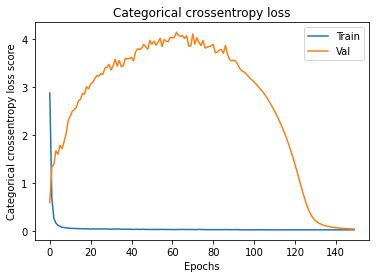

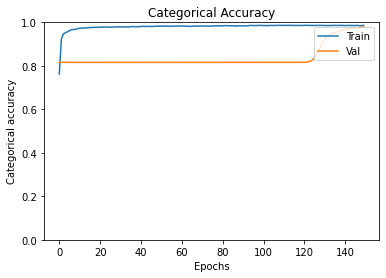

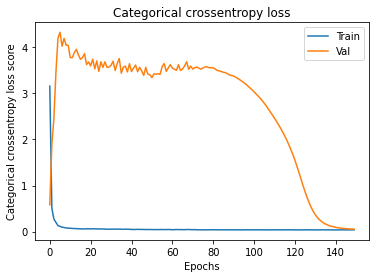

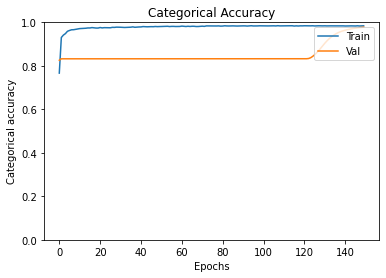

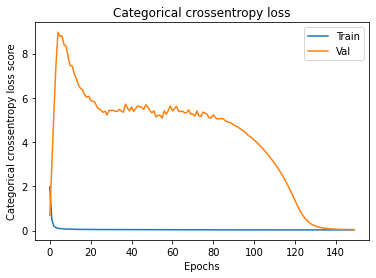

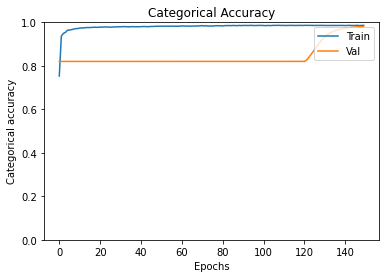

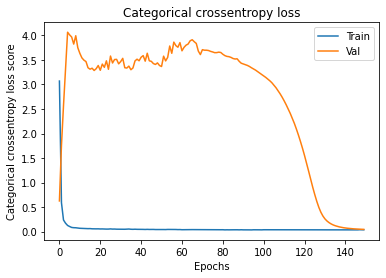

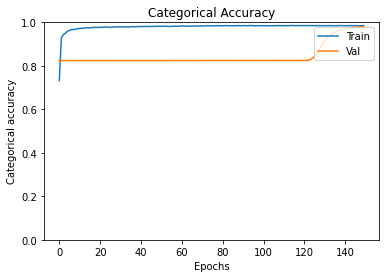

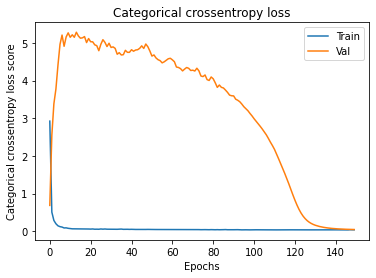

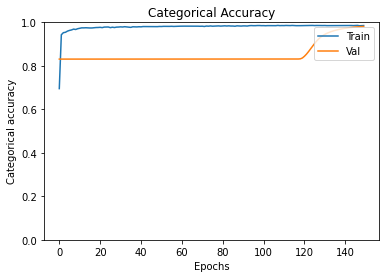

In [18]:
from tensorflow.keras import backend as K

# Prediction of all test images
def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)

data_by_fold = []

for j, (train_idx, val_idx) in foldsB:
    
    # Free up RAM in case the model definition cells were run multiple times
    K.clear_session()
    epochs = 150
    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    print('\nFold ',j)
    X_train_cv = images[train_idx]
    y_train_cv = masks[train_idx]
    X_valid_cv = images[val_idx]
    y_valid_cv = masks[val_idx]
    
    name_weights = ""
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    train_generator, val_generator = get_image_generator(data_gen_args, images=X_train_cv, masks=y_train_cv)
    
    model = get_model(input_shape, num_classes)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    history = model.fit(
        gen_dtype(train_generator),
        validation_data=(X_valid_cv, y_valid_cv),
        shuffle=True,
        steps_per_epoch=len(X_train_cv)/batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )
    
    f1 = plt.figure(2*j+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Categorical crossentropy loss')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical crossentropy loss score')
    plt.legend(['Train', 'Val'], loc='upper right')
    f1.show()

    f2 = plt.figure(2*j+2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Categorical Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical accuracy')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Val'], loc='upper right')
    f2.show()
    
    score = model.evaluate(images_test, masks_test, verbose=1)
    
    masks_test_from_pred = get_class_mask_from_prediction(masks_test)
    prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in model.predict(images_test)])
    
    df = custom_classification_report(masks_test_from_pred, prediction_masks_test)
    
    display(df)
    
    data_by_fold.append(df)


Fold  0


2022-01-20 22:36:57.909205: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-20 22:36:57.926079: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz
2022-01-20 22:36:59.300313: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-01-20 22:36:59.851709: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-01-20 22:37:00.425108: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-20 22:37:00.425131: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-01-20 22:37:00.425588: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-20 22:37:00.425630: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31


Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00131: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.


2022-01-20 22:40:21.704361: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.
2022-01-20 22:40:22.209098: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.


31/31 [==============================] - 5s 149ms/step - loss: 0.1704 - categorical_accuracy: 0.9518


2022-01-20 22:40:28.635044: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.
2022-01-20 22:40:32.641349: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.


background  \
precision                                                0.965534   
recall                                                   0.996565   
f1-score                                                 0.980804   
support                                                  30795773   
specificity                                              0.767968   
accuracy                                                 0.966177   
jaccard_score                                            0.962331   
hausdorff_dist  [13.416407864998739, 14.142135623730951, 16.76...   

                                                            media  \
precision                                                0.699624   
recall                                                   0.568026   
f1-score                                                 0.626995   
support                                                   2353746   
specificity                                              0.982892   
accuracy                                                 0.955697   
jaccard_score                                            0.456658   
hausdorff_dist  [16.97056274847714, 16.278820596099706, 19.849...   

                                                            lumen  
precision                                                0.971309  
recall                                                   0.788323  
f1-score                                                 0.870301  
support                                                   2903473  
specificity                                              0.997893  
accuracy                                                 0.980507  
jaccard_score                                            0.770383  
hausdorff_dist  [7.0, 6.0, 5.656854249492381, 10.4403065089105...

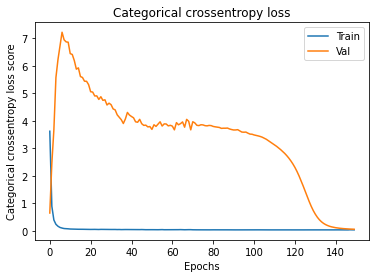

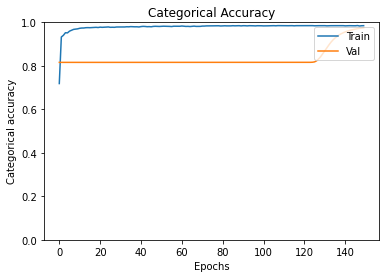

In [19]:
from tensorflow.keras import backend as K

# Prediction of all test images
def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)

data_by_fold = []

for j, (train_idx, val_idx) in [foldsB[0]]:
    
    # Free up RAM in case the model definition cells were run multiple times
    K.clear_session()
    epochs = 150
    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    print('\nFold ',j)
    X_train_cv = images[train_idx]
    y_train_cv = masks[train_idx]
    X_valid_cv = images[val_idx]
    y_valid_cv = masks[val_idx]
    
    name_weights = ""
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    train_generator, val_generator = get_image_generator(data_gen_args, images=X_train_cv, masks=y_train_cv)
    
    model = get_model(input_shape, num_classes)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    history = model.fit(
        gen_dtype(train_generator),
        validation_data=(X_valid_cv, y_valid_cv),
        shuffle=True,
        steps_per_epoch=len(X_train_cv)/batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )
    
    f1 = plt.figure(2*j+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Categorical crossentropy loss')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical crossentropy loss score')
    plt.legend(['Train', 'Val'], loc='upper right')
    f1.show()

    f2 = plt.figure(2*j+2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Categorical Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical accuracy')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Val'], loc='upper right')
    f2.show()
    
    score = model.evaluate(images_test, masks_test, verbose=1)
    
    masks_test_from_pred = get_class_mask_from_prediction(masks_test)
    prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in model.predict(images_test)])
    
    df = custom_classification_report(masks_test_from_pred, prediction_masks_test)
    
    display(df)
    
    data_by_fold.append(df)

In [19]:
data = data_by_fold[0].copy(deep=True)
for cls in ['background', 'media', 'lumen']:
    for metric in ['precision', 'recall', 'f1-score', 'accuracy', 'specificity', 'jaccard_score']:
        l = [fold[cls][metric] for fold in data_by_fold]
        data[cls][metric] = f"{np.mean(l)}({np.std(l)})"
    
    hausdorff_list = []
    for fold in data_by_fold:
        hausdorff_list += list(fold[cls]['hausdorff_dist'])
    
    data[cls]['hausdorff_dist'] = f"{np.mean(hausdorff_list)}({np.std(hausdorff_list)})"
    
display(data)
data.to_csv(os.path.join(os.getcwd(), "output", f"v{version}", "metrics-modelA.csv"))

background  \
precision        0.9714073042915594(0.001472796057372984)   
recall          0.9950223558278598(0.0006735937640880524)   
f1-score        0.9830726238920103(0.0009709318355469495)   
support                                          30795773   
specificity      0.8093147804981887(0.009792862175843813)   
accuracy        0.9702957703172853(0.0017093225764101465)   
jaccard_score    0.9667105726491931(0.001876762924573982)   
hausdorff_dist      13.717477824679468(8.399211454039744)   

                                                    media  \
precision         0.710223545860299(0.010259073131897643)   
recall           0.6214570306226755(0.014629970963072727)   
f1-score         0.6628375157341002(0.012043661154245754)   
support                                           2353746   
specificity     0.9822426115052265(0.0006505248164704725)   
accuracy          0.958626118081647(0.001307360687193526)   
jaccard_score   0.49582535312164977(0.013413746395031003)   
hausdorff_dist      14.321853244966695(8.634054193585767)   

                                                    lumen  
precision       0.9658474644104246(0.0035633184615240887)  
recall           0.8146397779486841(0.008287876702189802)  
f1-score           0.883783473929024(0.00370404983236204)  
support                                           2903473  
specificity     0.9973983404189026(0.0003018392727092741)  
accuracy        0.9822771332578464(0.0004693788432814798)  
jaccard_score    0.7917868338254584(0.005959760226832909)  
hausdorff_dist       9.229151971353751(7.591409773942837)

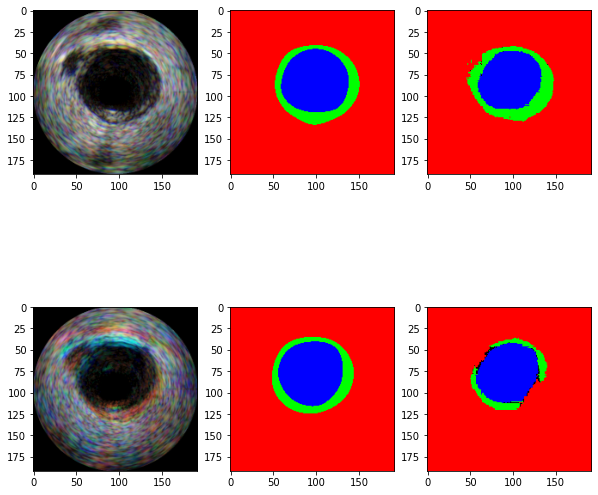

In [20]:
# Show some predictions from the training dataset
plt.figure(figsize=(10,10))

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

best_model = model

samples = 2

test_images = images[:samples]
test_masks = masks[:samples]
test_predictions = best_model.predict(test_images)

for i in range(samples):
    
    plt.subplot(samples, 3, 3*i + 1)
    plt.imshow(test_images[i])
    
    plt.subplot(samples, 3, 3*i + 2)
    plt.imshow(test_masks[i])
    
    plt.subplot(samples, 3, 3*i + 3)
    plt.imshow(get_mask_from_prediction(test_predictions[i]))

<Figure size 720x2880 with 0 Axes>

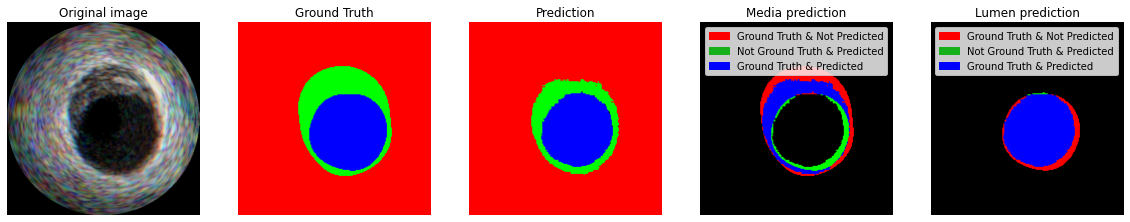

In [22]:
# Show some predictions from the test dataset
plt.figure(figsize=(10,40))

def get_mask_from_prediction(prediction):
    return np.rint(prediction)
tf.keras.backend.clear_session()

best_model=model

best_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

num = 252

test_images = images_test[num:num+1]
test_masks = masks_test[num:num+1]
test_predictions = best_model.predict(test_images)

print_predictions(
    test_images[0],
    test_masks[0],
    get_mask_from_prediction(test_predictions[0])
)

## Let's test our model

In [21]:
score = model.evaluate(images_test, masks_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

31/31 [==============================] - 4s 135ms/step - loss: 0.1417 - categorical_accuracy: 0.9580
Test loss: 0.14169612526893616
Test accuracy: 0.9580415487289429


In [21]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

def print_predictions(image, ground_truth, prediction, save_filename=None):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 5, 1)
    plt.title("Original image")
    plt.axis('off')
    plt.imshow(image)
    
    plt.subplot(1, 5, 2)
    plt.title("Ground Truth")
    plt.axis('off')
    plt.imshow(ground_truth)
    
    plt.subplot(1, 5, 3)
    plt.title("Prediction")
    plt.axis('off')
    plt.imshow(prediction) 
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", "v1", "masks_prediction", save_filename))

    handles = [
        mpatches.Patch(color='red', label='Ground Truth & Not Predicted'),
        mpatches.Patch(color='xkcd:green', label='Not Ground Truth & Predicted'),
        mpatches.Patch(color='blue', label='Ground Truth & Predicted')
    ]
    
    media_image = np.zeros(image.shape)
    media_image[:, :, 0][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==0)] = 1
    media_image[:, :, 1][(ground_truth[:, :, 1]==0) & (prediction[:, :, 1]==1)] = 1
    media_image[:, :, 2][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==1)] = 1
    plt.subplot(1, 5, 4)
    plt.title("Media prediction")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(media_image)
    
    lumen_image = np.zeros(image.shape)
    lumen_image[:, :, 0][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==0)] = 1
    lumen_image[:, :, 1][(ground_truth[:, :, 2]==0) & (prediction[:, :, 2]==1)] = 1
    lumen_image[:, :, 2][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==1)] = 1
    plt.subplot(1, 5, 5)
    plt.title("Lumen prediction")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(lumen_image)
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", "v0", "predictions", save_filename))

<Figure size 720x2880 with 0 Axes>

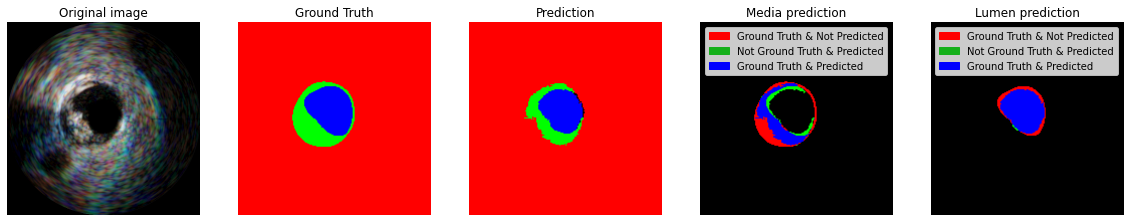

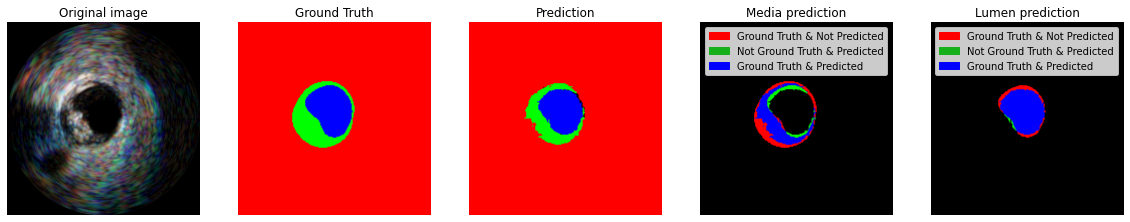

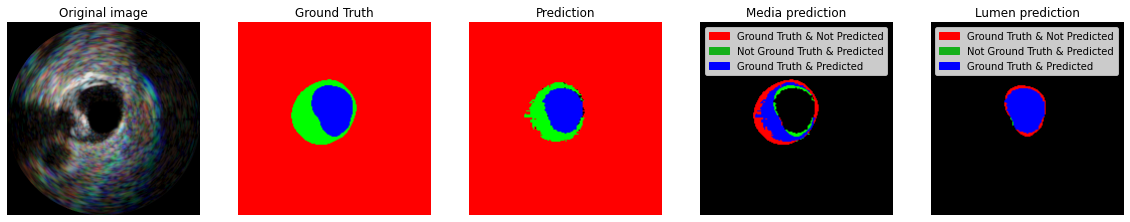

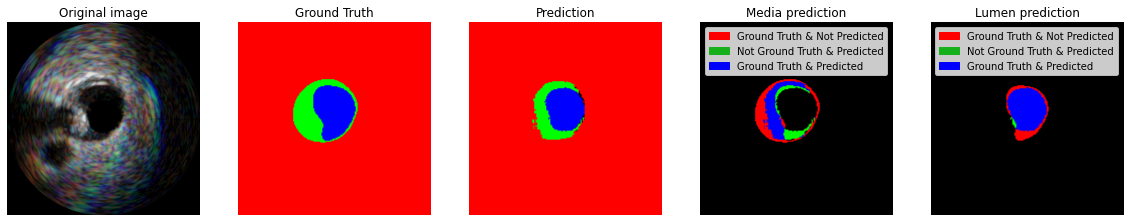

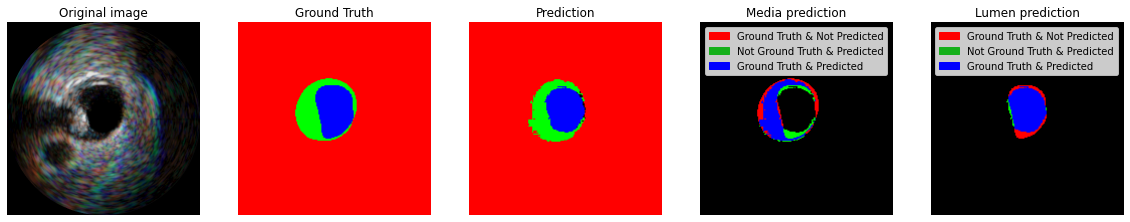

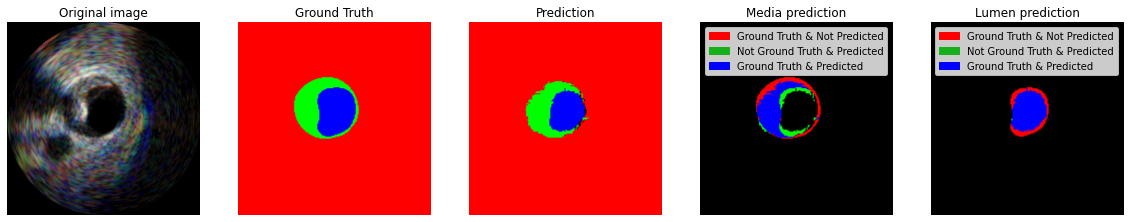

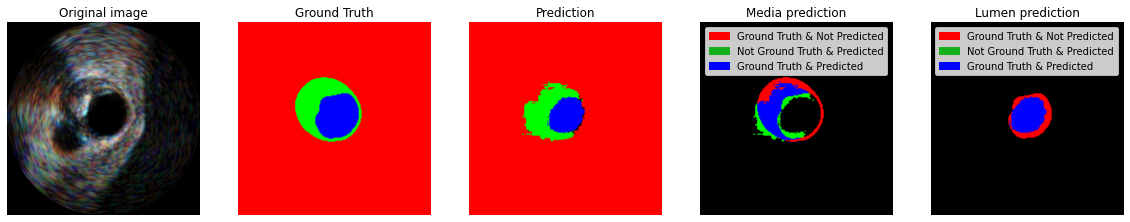

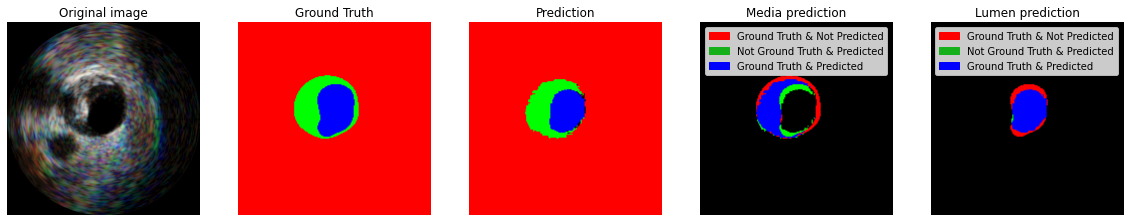

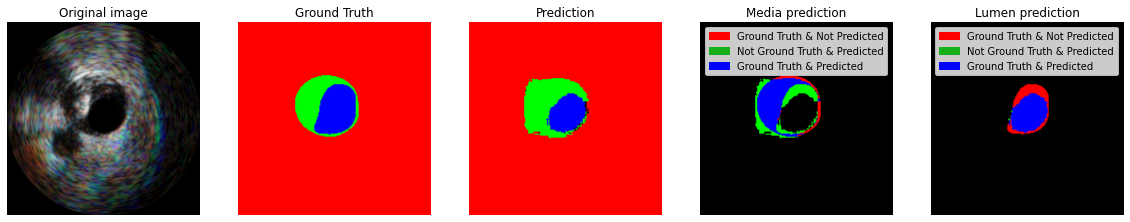

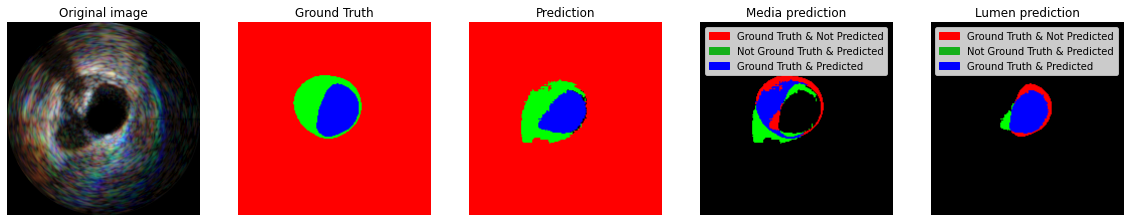

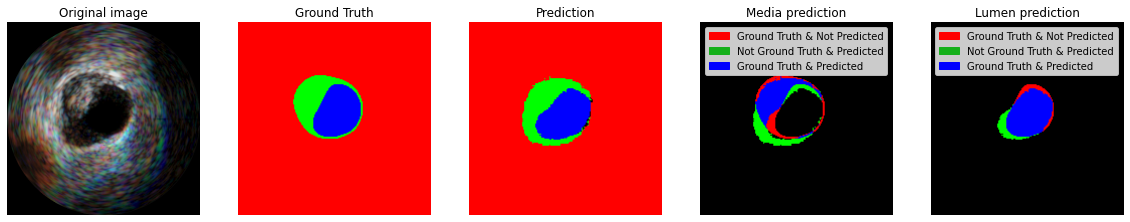

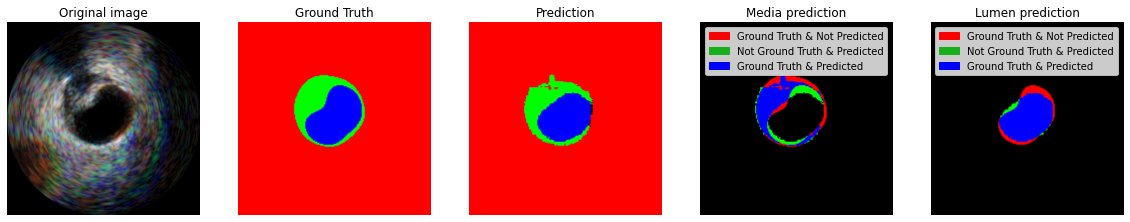

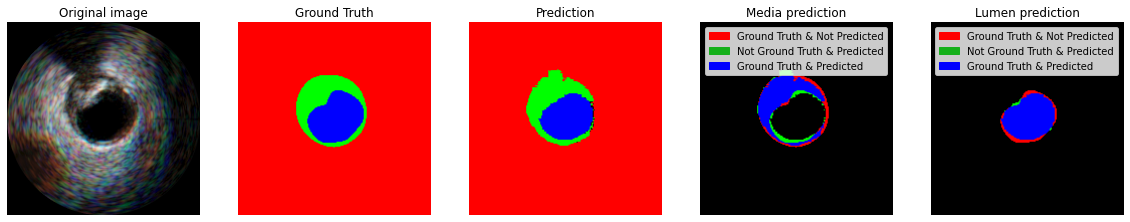

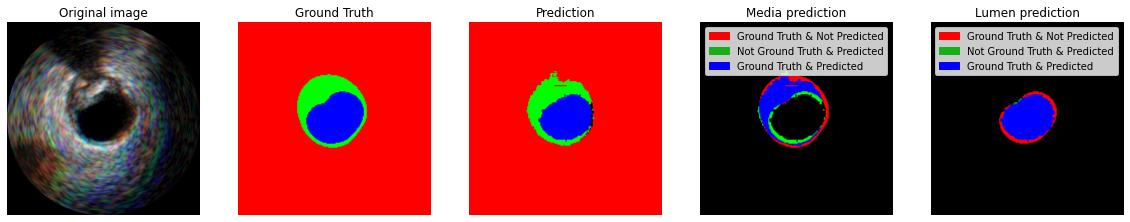

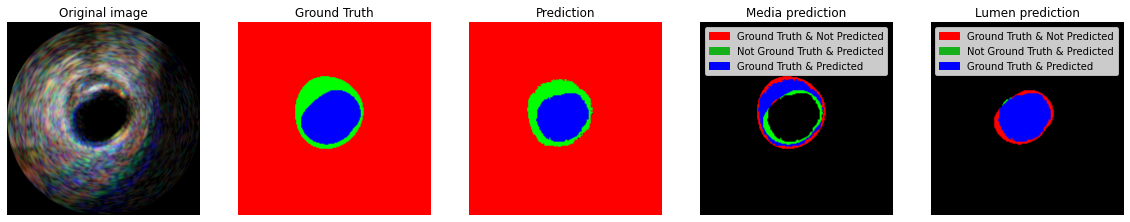

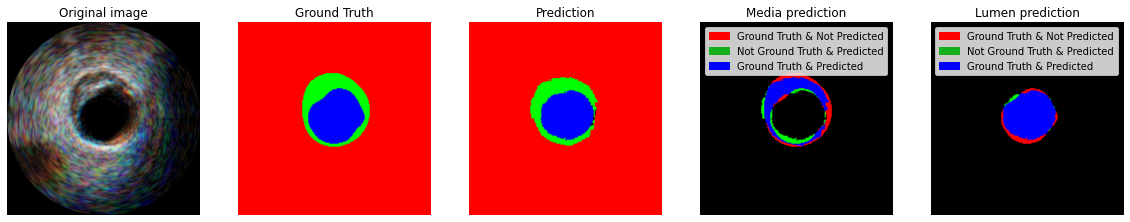

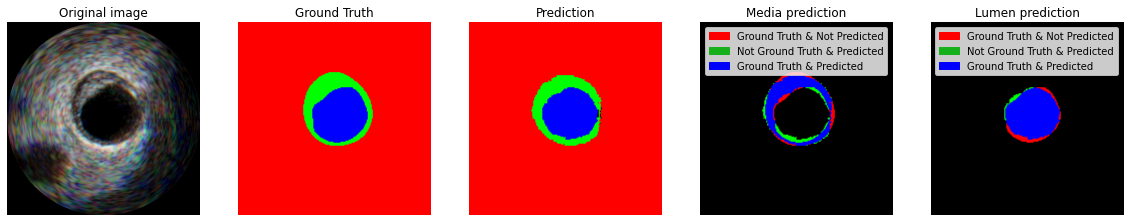

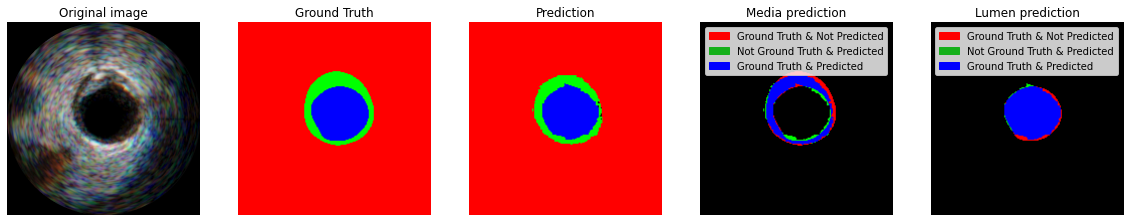

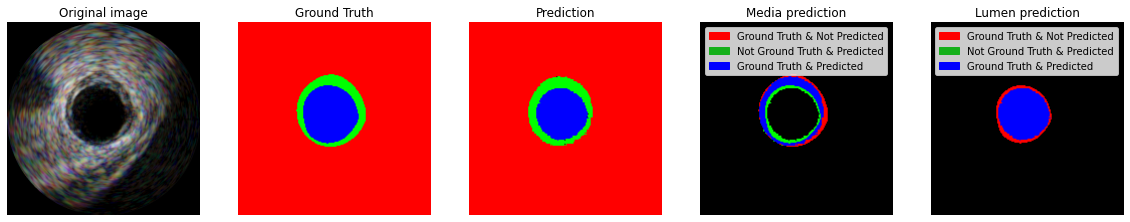

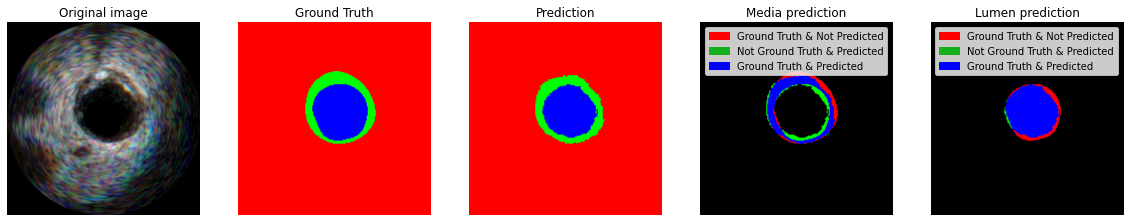

In [28]:
# Show some predictions from the test dataset
plt.figure(figsize=(10,40))

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

samples = 20

test_images = images_test[:samples]
test_masks = masks_test[:samples]
test_predictions = model.predict(test_images)

for i in range(samples):
    save_filename=f"frame_03_00{10+i:02}_003.png"
    print_predictions(
        test_images[i],
        test_masks[i],
        get_mask_from_prediction(test_predictions[i]),
        save_filename=save_filename
    )

In [21]:
# Prediction of all test images
def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)
    
masks_test = get_class_mask_from_prediction(masks_test)
prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in best_model.predict(images_test)])

2022-01-20 22:42:39.015027: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.


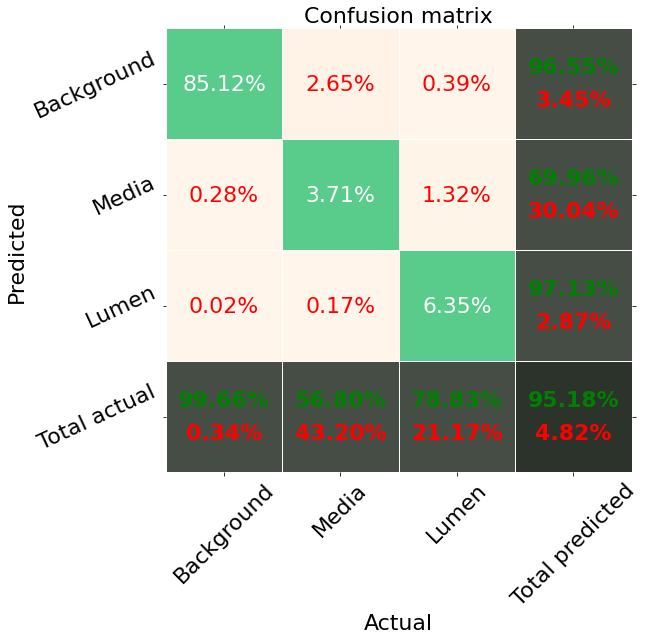

In [22]:
from Challenge_measures.confusion_matrix_pretty_print import pp_matrix_from_data
pp_matrix_from_data(
    masks_test.flatten(),
    prediction_masks_test.flatten(),
    columns=['Background', 'Media', 'Lumen'],
    fz=22
)